# AGN Pop Task Force - Light Curves and Spectrum Tests

Our goals:

1) To reproduce one or two lightcurves from the LAT repository with the downloaded data. Make sure if you plot yourself those lightcurves, you reach an identical LC.
2) To be able to read the generated modified 4LAC catalogs (the outputs of the "4LAC_catalog_generator") and show that you are able to plot the spectrum of all sources. Be aware in this link: " https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/ " , you can not only download the 4FGL catalog and check its associated paper, there is also one section in which you can download figures of all spectra. That means that you can select a single source, and compare your plot with those in this links.
3) Once you have a source spectrum (from 2) now the objective is to make sure you can properly integrate the average flux between the 2 energies you want. This should be trivial with python (just the integral of a function).
4) Add the average flux state to the lightcurves you generate in 1), and confirm they more or less make sense
5) "Normalize" each lightcurve with respect to the average state we will be considering


Fermi LAT Light Curve Repository:
https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/

In [1]:
# Astro imports

from astropy.io import fits
import numpy as np
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii
import os
import json
import urllib.request

from astropy import units as u

from astropy.time import Time,TimeUnix
from datetime import datetime

In [2]:
# Other imports

import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sp
import scipy.odr.odrpack as odrpack
from scipy import signal, integrate
from scipy.fft import fft, fftfreq
import numpy as np
import statistics
import csv
import math
from scipy.fft import fft, fftfreq

import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter

In [3]:
# Functions


# time in LAT is done using MET (seconds) from January 1st, 2001 until now
# https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/Time_in_ScienceTools.html

# convert time from MET to UTC
def convert_MET_UTC(time_MET):
    
    # changing data to Unix (referencial of 1970)
    time_Unix = Time(time_MET, format='unix', scale='utc')

    # finding how many seconds are there from 1970 to January 1st, 2001
    time_difference = Time('2001-01-01', format='iso', scale='utc')
    time_difference.format = 'unix'
    time_difference.value

    # increased the diffence of time between 2001 and 1970 to my data
    time_MET_copy = np.copy(time_MET)
    time_MET_copy += time_difference.value

    # transform into year: format='iso'
    time_Unix = Time(time_MET_copy, format='unix', scale='utc')
    time_Unix.format = 'iso'
    time_Unix

    # list with only date values, year, month and day
    time_UTC = []
    for i in range(len(time_Unix.value)):
        time_UTC.append(datetime.strptime(time_Unix.value[i][:10], '%Y-%m-%d'))

    return time_UTC

### STEP 1

We will try to reproduce two lightcurves from the LAT repository with the downloaded data.
Making sure we reach an identical LC. 

4FGL J0010.6-3025, PKS 0008-307 - PowerLaw

4FGL J0016.2-0016, S3 0013-00 - LogParabola

#### PKS 0008-307 

https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/source.html?source_name=4FGL_J0010.6-3025

In [4]:
# opening JSON file

file1 = open('4FGL+J0010.6-3025.json')

# returns JSON object as a dictionary
data1 = json.load(file1)

print(data1.keys())

# data['flux'] to select only the flux

dict_keys(['ts', 'flux', 'flux_upper_limits', 'flux_error', 'photon_index', 'photon_index_interval', 'fit_tolerance', 'fit_convergence', 'dlogl', 'EG', 'GAL', 'bin_id'])


In [5]:
# creating arrays to store the data

time1 = np.array(data1['flux'])[:,0]     # 'flux' [i][0]
flux1 = np.array(data1['flux'])[:,1]     # 'flux' [i][1]

time1_error      = np.array(data1['flux_error'])[:,0]     # 'flux_error' [i][0]
flux1_low_error  = np.array(data1['flux_error'])[:,1]     # 'flux_error' [i][1]  - lower flux edge
flux1_high_error = np.array(data1['flux_error'])[:,2]     # 'flux_error' [i][2]  - high edge

time1_upper_lim  = np.array(data1['flux_upper_limits'])[:,0]     # 'flux_upper_limits' [i][0]
flux1_upper_lim  = np.array(data1['flux_upper_limits'])[:,1]     # 'flux_upper_limits' [i][1]

In [6]:
# # conversion of time from MET to UTC

# time1_UTC = convert_MET_UTC(time1)
# time1_error_UTC = convert_MET_UTC(time1_error)
# time1_upper_lim_UTC = convert_MET_UTC(time1_upper_lim)

In [7]:
# # plotting the flux with its error and the upper limits as a function of the date in UTC

# plt.figure(figsize=(17,5), dpi=300)

# # flux
# plt.plot(time1_UTC, flux1, '.', markersize=10)
# plt.plot(time1_UTC, flux1, linewidth=0.4, color='black')

# # plt.xticks(np.arange(2009, 2022, 1))

# # upper_limits
# plt.plot(time1_upper_lim_UTC, flux1_upper_lim, 'v', color='gray', markersize=3, alpha=0.45)

# # error_bar
# # plt.plot(time1_error_UTC, flux1_low_error, 'x', color='green', markersize=3, alpha=0.3)  # visualize the error
# # plt.plot(time1_error_UTC, flux1_high_error, 'x', color='red', markersize=3, alpha=0.3)   # visualize the error
# plt.errorbar(time1_error_UTC, flux1, yerr=flux1_high_error-flux1, linewidth=0.2, color='black', alpha=0.9)
# plt.errorbar(time1_error_UTC, flux1, yerr=flux1-flux1_low_error, linewidth=0.2, color='black', alpha=0.9)



# # plt.errorbar(time1, flux1, yerr=[flux1_low_error, flux1_high_error], linewidth=0.2, color='black', alpha=0.5)

# # plt.errorbar(time1, flux1, yerr=flux1_high_error-flux1_low_error,
# #              lolims=flux1_low_error, uplims=flux1_high_error, linewidth=0.2, color='black')


# dif = time1_upper_lim_UTC[6] - time1_upper_lim_UTC[0]

# plt.xlim(time1_upper_lim_UTC[0]-dif, time1_upper_lim_UTC[-1]+dif)
# plt.ylim(0, np.min(flux1)*40)
# plt.title('PKS 0008-307 4LAC Light Curve', fontsize='xx-large')
# plt.xlabel('Date (UTC)', fontsize=12)
# plt.ylabel('Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=12)

Text(0, 0.5, 'Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)')

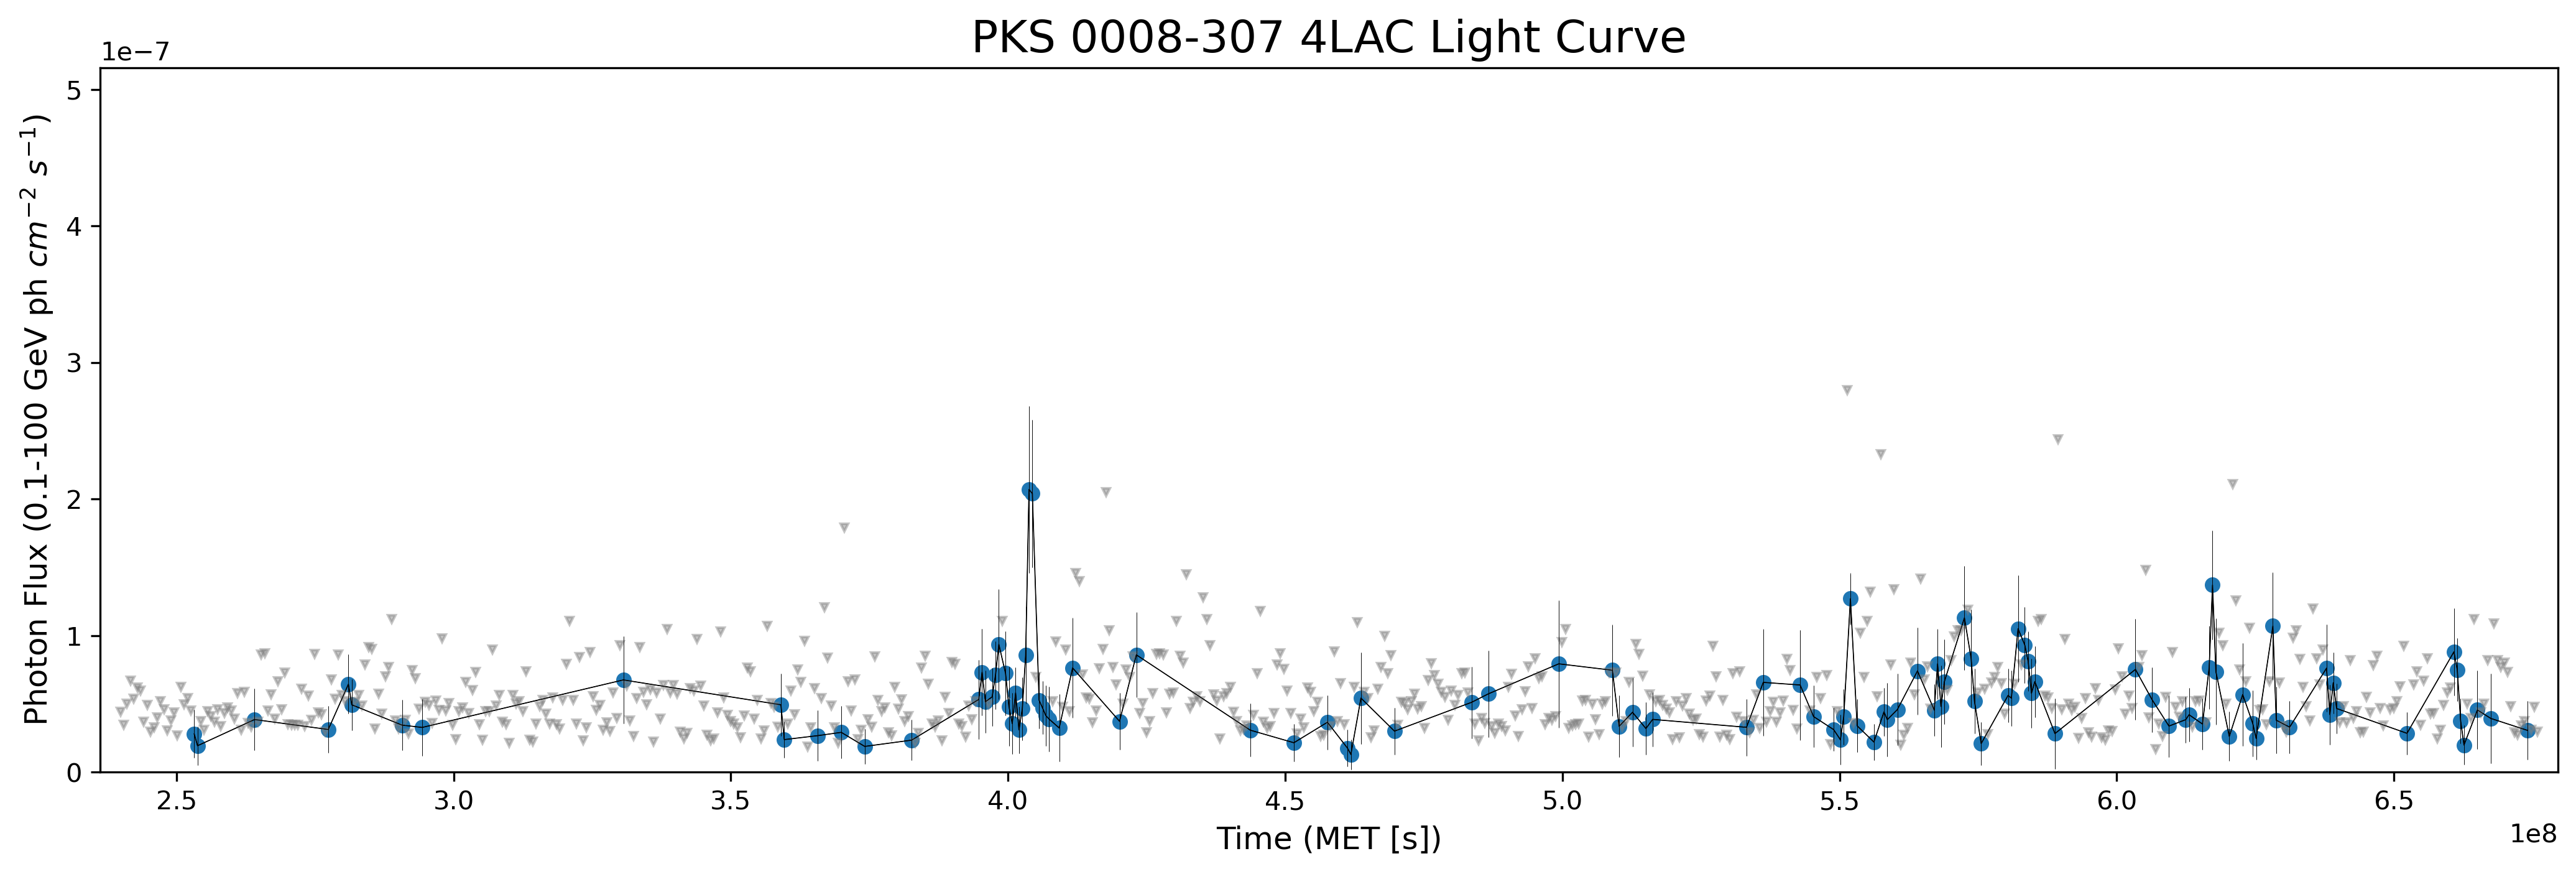

In [8]:
# plotting the flux with its error and the upper limits as a function of flux[0]

plt.figure(figsize=(17,5), dpi=300)

# flux
plt.plot(time1, flux1, '.', markersize=10)
plt.plot(time1, flux1, linewidth=0.4, color='black')

# upper_limits
plt.plot(time1_upper_lim, flux1_upper_lim, 'v', color='gray', markersize=3, alpha=0.45)

# error_bar
# plt.plot(time1_error, flux1_low_error, 'x', color='green', markersize=3, alpha=0.3)  # visualize the error
# plt.plot(time1_error, flux1_high_error, 'x', color='red', markersize=3, alpha=0.3)   # visualize the error
plt.errorbar(time1, flux1, yerr=flux1_high_error-flux1, linewidth=0.2, color='black', alpha=0.9)
plt.errorbar(time1, flux1, yerr=flux1-flux1_low_error, linewidth=0.2, color='black', alpha=0.9)


dif = time1_upper_lim[6] - time1_upper_lim[0]

plt.xlim(time1_upper_lim[0]-dif, time1_upper_lim[-1]+dif)
plt.ylim(0, np.min(flux1)*40)
plt.title('PKS 0008-307 4LAC Light Curve', fontsize='xx-large')
plt.xlabel('Time (MET [s])', fontsize=12)
plt.ylabel('Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=12)

#### S3 0013-00

https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/source.html?source_name=4FGL_J0016.2-0016

In [9]:
# opening JSON file

file2 = open('4FGL+J0016.2-0016.json')
 
# returns JSON object as a dictionary
data2 = json.load(file2)

print(data2.keys())

# data['flux'] to select only the flux

dict_keys(['ts', 'flux', 'flux_upper_limits', 'flux_error', 'photon_index', 'photon_index_interval', 'fit_tolerance', 'fit_convergence', 'dlogl', 'EG', 'GAL', 'bin_id'])


In [10]:
# creating arrays to store the data

time2 = np.array(data2['flux'])[:,0]     # 'flux' [i][0]
flux2 = np.array(data2['flux'])[:,1]     # 'flux' [i][1]

time2_error      = np.array(data2['flux_error'])[:,0]     # 'flux_error' [i][0]
flux2_low_error  = np.array(data2['flux_error'])[:,1]     # 'flux_error' [i][1]  - lower flux edge
flux2_high_error = np.array(data2['flux_error'])[:,2]     # 'flux_error' [i][2]  - high edge

time2_upper_lim  = np.array(data2['flux_upper_limits'])[:,0]     # 'flux_upper_limits' [i][0]
flux2_upper_lim  = np.array(data2['flux_upper_limits'])[:,1]     # 'flux_upper_limits' [i][1]

In [11]:
# # conversion of time from MET to UTC

# time2_UTC = convert_MET_UTC(time2)
# time2_error_UTC = convert_MET_UTC(time2_error)
# time2_upper_lim_UTC = convert_MET_UTC(time2_upper_lim)

In [12]:
# # plotting the flux with its error and the upper limits as a function of the date in UTC

# plt.figure(figsize=(17,5), dpi=300)

# # flux
# plt.plot(time2_UTC, flux2, '.', markersize=10)
# plt.plot(time2_UTC, flux2, linewidth=0.4, color='black')

# # upper_limits
# plt.plot(time2_upper_lim_UTC, flux2_upper_lim, 'v', color='gray', markersize=3, alpha=0.45)

# # error_bar
# # plt.plot(time2_error_UTC, flux2_low_error, 'x', color='green', markersize=3, alpha=0.3)  # visualize the error
# # plt.plot(time2_error_UTC, flux2_high_error, 'x', color='red', markersize=3, alpha=0.3)   # visualize the error
# plt.errorbar(time2_error_UTC, flux2, yerr=flux2_high_error-flux2, linewidth=0.2, color='black', alpha=0.9)
# plt.errorbar(time2_error_UTC, flux2, yerr=flux2-flux2_low_error, linewidth=0.2, color='black', alpha=0.9)

# dif = time2_upper_lim_UTC[6] - time2_upper_lim_UTC[0]

# plt.xlim(time2_upper_lim_UTC[0]-dif, time2_upper_lim_UTC[-1]+dif)
# plt.ylim(0, np.min(flux2)*27)
# plt.title('S3 0013-00 4LAC Light Curve', fontsize='xx-large')
# plt.ylabel('Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=12)
# plt.xlabel('Date (UTC)', fontsize=12)

Text(0.5, 0, 'Time (MET s)')

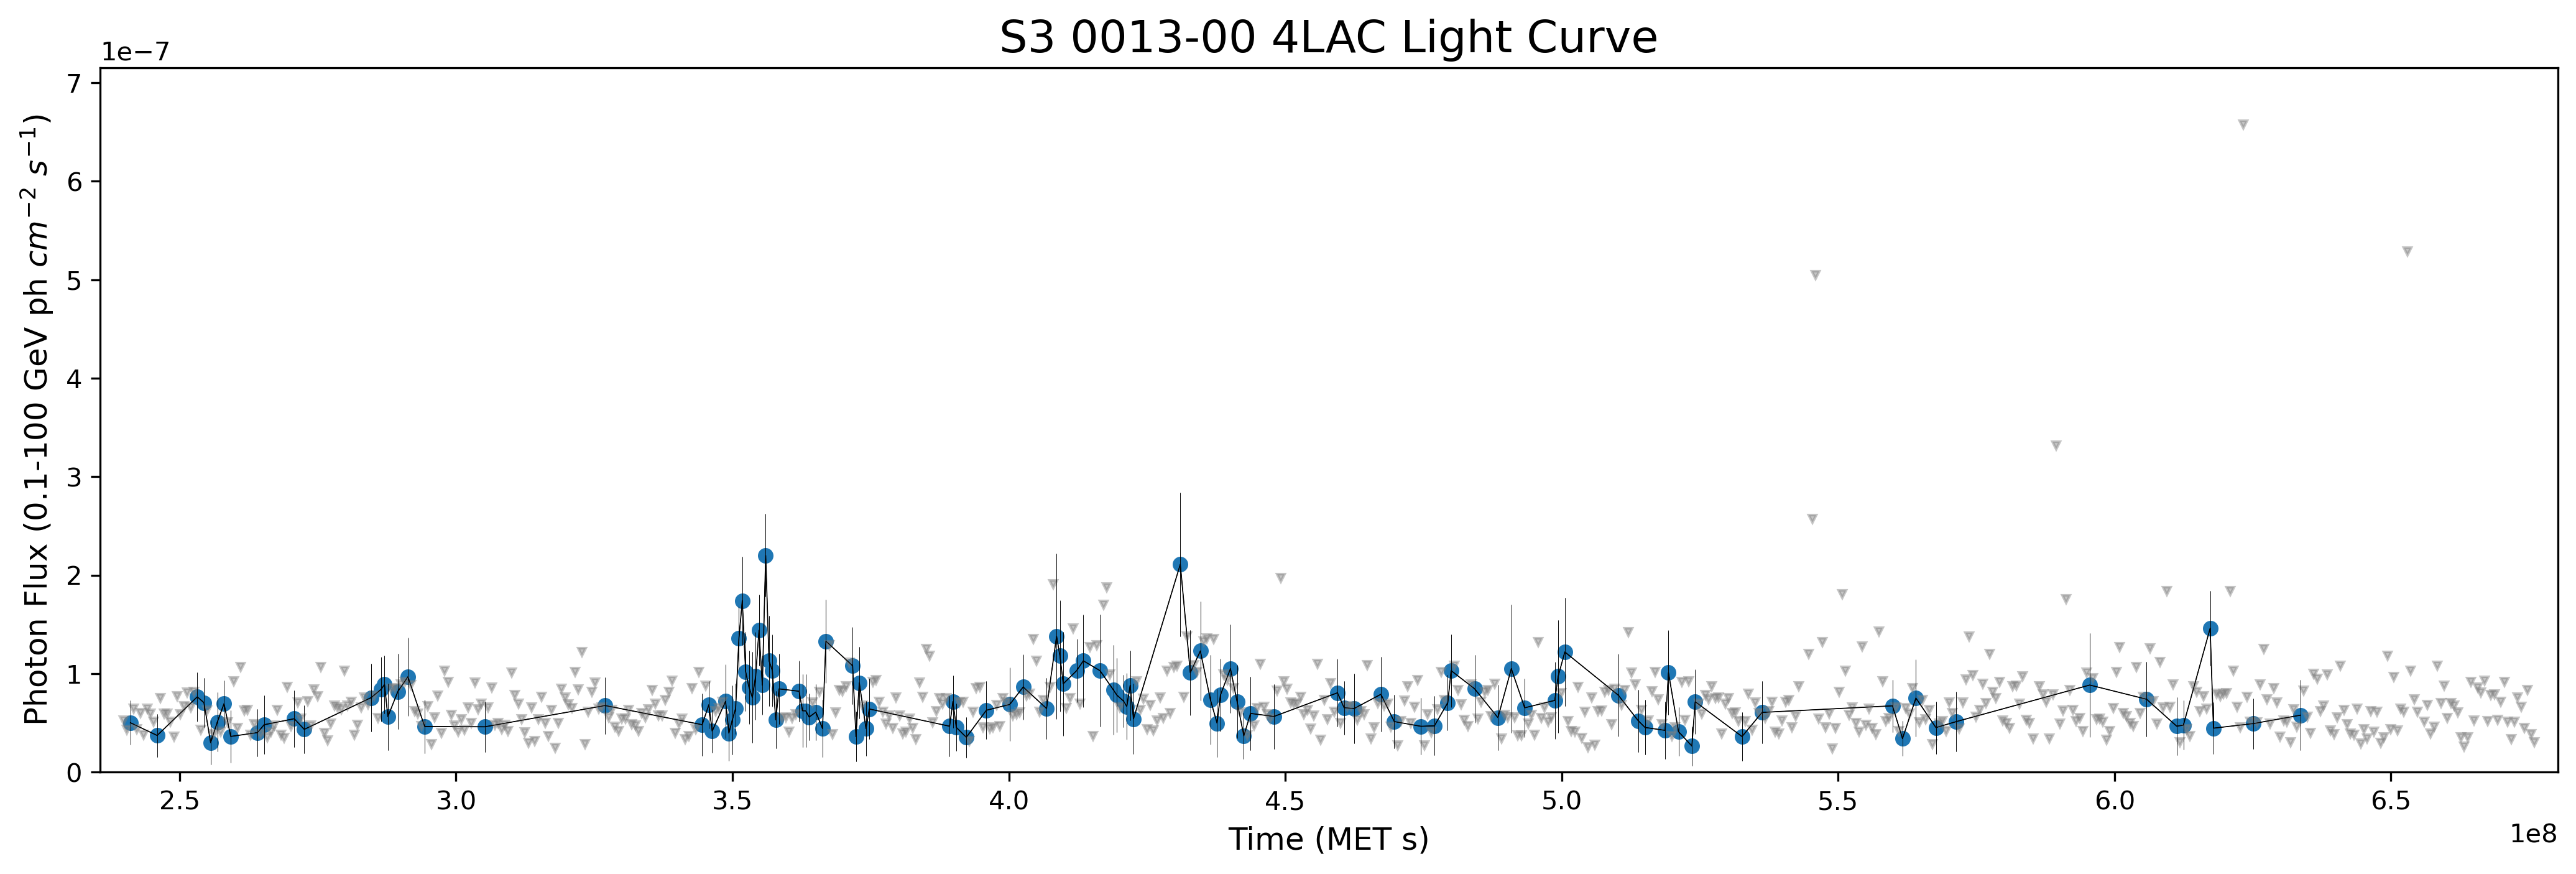

In [13]:
# plotting the flux with its error and the upper limits as a function of flux[0]

plt.figure(figsize=(17,5), dpi=300)

# flux
plt.plot(time2, flux2, '.', markersize=10)
plt.plot(time2, flux2, linewidth=0.4, color='black')

# upper_limits
plt.plot(time2_upper_lim, flux2_upper_lim, 'v', color='gray', markersize=3, alpha=0.45)

# error_bar
# plt.plot(time2_error, flux2_low_error, 'x', color='green', markersize=3, alpha=0.3)  # visualize the error
# plt.plot(time2_error, flux2_high_error, 'x', color='red', markersize=3, alpha=0.3)   # visualize the error
plt.errorbar(time2, flux2, yerr=flux2_high_error-flux2, linewidth=0.2, color='black', alpha=0.9)
plt.errorbar(time2, flux2, yerr=flux2-flux2_low_error, linewidth=0.2, color='black', alpha=0.9)

dif = time2_upper_lim[6] - time2_upper_lim[0]

plt.xlim(time2_upper_lim[0]-dif, time2_upper_lim[-1]+dif)
plt.ylim(0, np.min(flux2)*27)
plt.title('S3 0013-00 4LAC Light Curve', fontsize='xx-large')
plt.ylabel('Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=12)
plt.xlabel('Time (MET s)', fontsize=12)

### STEP 2


To be able to read the generated modified 4LAC catalogs (the outputs of the "4LAC_catalog_generator") and show that you are able to plot the spectrum of all sources. Be aware in this link: " https://fermi.gsfc.nasa.gov/ssc/data/access/lat/10yr_catalog/ " , you can not only download the 4FGL catalog and check its associated paper, there is also one section in which you can download figures of all spectra. That means that you can select a single source, and compare your plot with those in this links.

https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/table_description.html

https://ui.adsabs.harvard.edu/abs/1996ApJ...461..396M/abstract

Using the equation (2) in page 13 of the following paper:

https://arxiv.org/pdf/1902.10045.pdf

The function for the logparabola is

$ \frac{dN}{dE} = K \left ( \frac{E}{E_0} \right )^{-\alpha -\beta\  log (E/ E_0)} $



K - flux density

E_0 - pivot energy

alpha - power law index if we have a power law

Lp index - index of the log parabola function



We will use this function for both PowerLaw (in which Beta disappears) and LogParabola spectrum type


Differential flux

$ E^2\ \frac{dN}{dE} = E^2\ K \left ( \frac{E}{E_0} \right )^{-\alpha -\beta\  log (E/ E_0)} $


That's an average state over 10 years of emission of these sources, and we want to compare how variable they are with respect to their average, calculating the flux in the spectrum - integral between energies and convert the units of these light curves, we want to change the units of each light curve with respect to their average state, select one or two sources powerlaw and log parabola and compare to the SED plots


In [7]:
## functions


# PARAMETERS MUST BE GIVEN IN CGS UNITS!


# returns 'erg cm-2 s-1'
def diff_flux(E, E_0, K, alpha, beta=None):
    
    if (beta == None):
        Y = E**2 * K * ((E/E_0)**(-alpha))
    else:
        Y = E**2 * K * ((E/E_0)**(-alpha - (beta * np.log(E/E_0))))
        
    return Y



# dN/dE in 'erg-1 cm-2 s-1'
def dNdE(E, E_0, K, alpha, beta=None):
    
    if (beta == None):
        Y = K * ((E/E_0)**(-alpha))
    else:
        Y = K * ((E/E_0)**(-alpha - (beta * np.log(E/E_0))))
        
    return Y

Text(0.5, 0, 'Energy (GeV)')

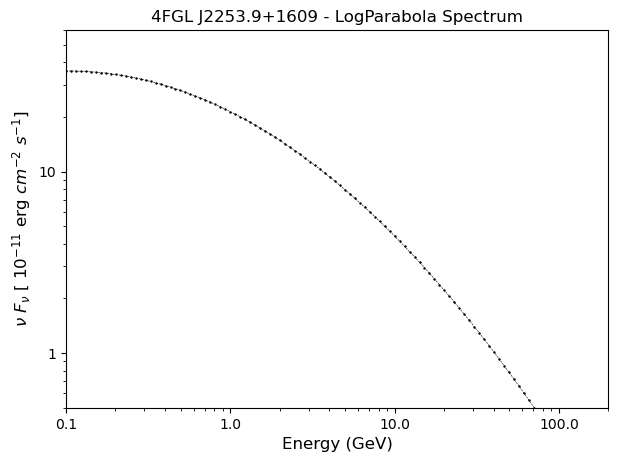

In [8]:
# LogParabola Spectrum


# J2253.9+1609 - LogParabola Spectrum


E1     = (np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')     # log scale of Energy in erg
E1_0   = (232.35162 * u.MeV).to('erg')                                          # Pivot_Energy in erg
K1     = (3.874912e-09 * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')   # LP_Flux_Density in erg-1 cm-2 s-1
alpha1 = 2.1620116                                                              # LP_Index
beta1  = 0.10028907                                                             # LP_beta


# PARAMETERS MUST BE GIVEN AS IT FOLLOWS: E: erg, E_0: erg, K: erg-1 cm-2 s-1, alpha: adimensional, ?beta: adimensional
# function returns differential flux in 'erg cm-2 s-1'
Y1 = diff_flux(E1, E1_0, K1, alpha1, beta1)


plt.figure(figsize=(7,5), dpi=100)

plt.plot(E1.to('GeV'), Y1*10**(11), '+', markersize=2, color='black')
plt.plot(E1.to('GeV'), Y1*10**(11), '--', linewidth=0.4, color='black')

plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%i'))

plt.xlim(0.1, 200)
plt.ylim(0.5, 60)

plt.title('4FGL J2253.9+1609 - LogParabola Spectrum', fontsize='large')
plt.ylabel(r'$\nu\ F_{\nu}$ [ $ 10^{-11} $ erg $cm^{-2}$ $s^{-1}$]', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)

Text(0.5, 0, 'Energy (GeV)')

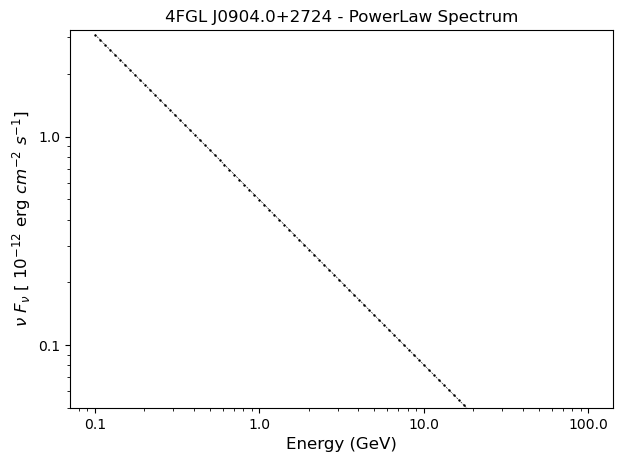

In [19]:
# PowerLaw Spectrum


# J0904.0+2724 - PowerLaw Spectrum


E2     = (np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')      # log scale of Energy in erg
E2_0   = (396.79605 * u.MeV).to('erg')                                           # Pivot_Energy in erg
K2     = (4.1177946e-12 * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')   # PL_Flux_Density in erg-1 cm-2 s-1
alpha2 = 2.7927804                                                               # PL_Index


# PARAMETERS MUST BE GIVEN AS IT FOLLOWS: E: erg, E_0: erg, K: erg-1 cm-2 s-1, alpha: adimensional, ?beta: adimensional
# function returns differential flux in 'erg cm-2 s-1'
Y2 = diff_flux(E2, E2_0, K2, alpha2)


plt.figure(figsize=(7,5), dpi=100)

plt.plot(E2.to('GeV'), Y2*10**(12), '+', markersize=2, color='black')
plt.plot(E2.to('GeV'), Y2*10**(12), '--', linewidth=0.4, color='black')

plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# plt.xlim(0.099, 110)
plt.ylim(0.05, 3.25)

plt.title('4FGL J0904.0+2724 - PowerLaw Spectrum', fontsize='large')
plt.ylabel(r'$\nu\ F_{\nu}$ [ $ 10^{-12} $ erg $cm^{-2}$ $s^{-1}$]', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)

Text(0.5, 0, 'Energy (GeV)')

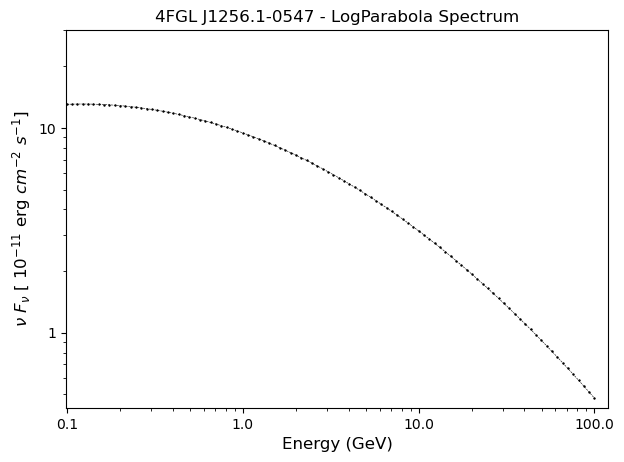

In [20]:
# LogParabola Spectrum


# J1256.1-0547 - LogParabola Spectrum


E3     = (np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')     # log scale of Energy in erg
E3_0   = (466.0457 * u.MeV).to('erg')                                           # Pivot_Energy in erg
K3     = (3.298064e-10 * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')   # LP_Flux_Density in erg-1 cm-2 s-1
alpha3 = 2.1964812                                                              # LP_Index
beta3  = 0.07365552                                                             # LP_beta


# PARAMETERS MUST BE GIVEN AS IT FOLLOWS: E: erg, E_0: erg, K: erg-1 cm-2 s-1, alpha: adimensional, ?beta: adimensional
# function returns differential flux in 'erg cm-2 s-1'
Y3 = diff_flux(E3, E3_0, K3, alpha3, beta3)


plt.figure(figsize=(7,5), dpi=100)

plt.plot(E3.to('GeV'), Y3*10**(11), '+', markersize=2, color='black')
plt.plot(E3.to('GeV'), Y3*10**(11), '--', linewidth=0.4, color='black')

plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%i'))

plt.xlim(0.099, 120)
plt.ylim(0.43, 30)

plt.title('4FGL J1256.1-0547 - LogParabola Spectrum', fontsize='large')
plt.ylabel(r'$\nu\ F_{\nu}$ [ $ 10^{-11} $ erg $cm^{-2}$ $s^{-1}$]', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)

Text(0.5, 0, 'Energy (GeV)')

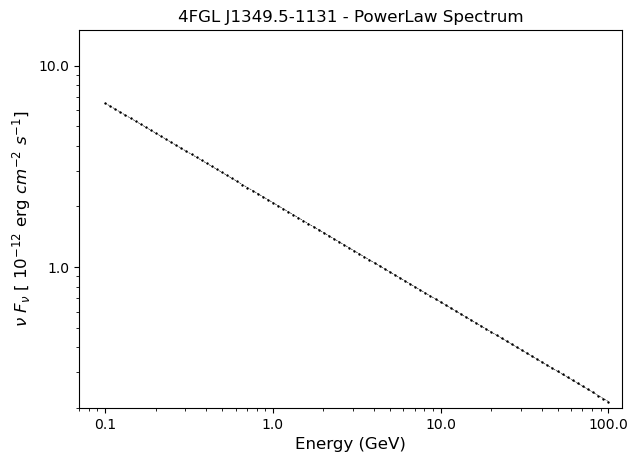

In [21]:
# PowerLaw Spectrum


# J1349.5-1131 - PowerLaw Spectrum


E4     = (np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')      # log scale of Energy in erg
E4_0   = (735.9257 * u.MeV).to('erg')                                            # Pivot_Energy in erg
K4     = (2.8009671e-12 * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')   # PL_Flux_Density in erg-1 cm-2 s-1
alpha4 = 2.4940784                                                               # PL_Index


# PARAMETERS MUST BE GIVEN AS IT FOLLOWS: E: erg, E_0: erg, K: erg-1 cm-2 s-1, alpha: adimensional, ?beta: adimensional
# function returns differential flux in 'erg cm-2 s-1'
Y4 = diff_flux(E4, E4_0, K4, alpha4)


plt.figure(figsize=(7,5), dpi=100)

plt.plot(E4.to('GeV'), Y4*10**(12), '+', markersize=2, color='black')
plt.plot(E4.to('GeV'), Y4*10**(12), '--', linewidth=0.4, color='black')

plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xlim(0.07, 120)
plt.ylim(0.2, 15)

plt.title('4FGL J1349.5-1131 - PowerLaw Spectrum', fontsize='large')
plt.ylabel(r'$\nu\ F_{\nu}$ [ $ 10^{-12} $ erg $cm^{-2}$ $s^{-1}$]', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)

In [22]:
(1 * u.TeV).to('erg')

<Quantity 1.60217663 erg>

Text(0.5, 0, 'Energy (GeV)')

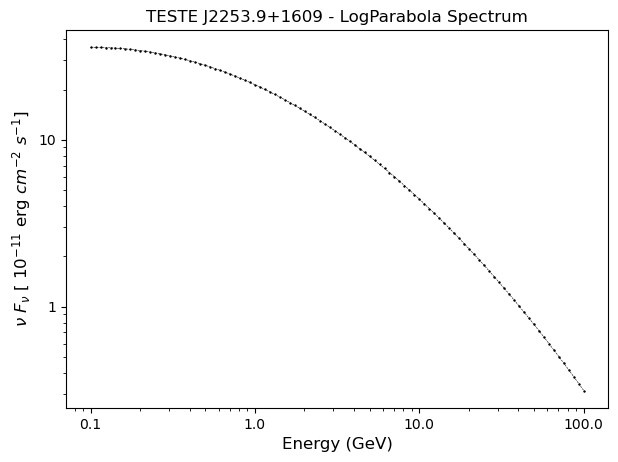

In [17]:
# TESTE


# J2253.9+1609 - LogParabola Spectrum


En     = (np.logspace(np.log10(0.1), np.log10(100), 100) * u.GeV).to('erg')     # log scale of Energy in erg
En_0   = (232.35162 * u.MeV).to('erg')                                          # Pivot_Energy in erg
Kn     = (3.874912e-09 * u.MeV**-1 * u.cm**-2 * u.s**-1).to('erg-1 cm-2 s-1')   # LP_Flux_Density in erg-1 cm-2 s-1
alphan = 2.1620116                                                              # LP_Index
betan  = 0.10028907                                                             # LP_beta


# PARAMETERS MUST BE GIVEN AS IT FOLLOWS: E: erg, E_0: erg, K: erg-1 cm-2 s-1, alpha: adimensional, ?beta: adimensional
# function returns differential flux in 'erg cm-2 s-1'
Yn = diff_flux(En, En_0, Kn, alphan, betan)


plt.figure(figsize=(7,5), dpi=100)

plt.plot(En.to('GeV'), Yn*10**(11), '+', markersize=2, color='black')
plt.plot(En.to('GeV'), Yn*10**(11), '--', linewidth=0.4, color='black')

plt.xscale('log')
plt.yscale('log')

# plt.xlim(0, 250)
# plt.ylim(0, 60)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%i'))

plt.title('TESTE J2253.9+1609 - LogParabola Spectrum', fontsize='large')
plt.ylabel(r'$\nu\ F_{\nu}$ [ $ 10^{-11} $ erg $cm^{-2}$ $s^{-1}$]', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)

In [23]:
(1* u.kg).to('g')

<Quantity 1000. g>

### STEP 3

Integrate the average flux of the source spectrum (from step 2) between the 2 energies I want.
This should be trivial with python (just the integral of a function).


In [24]:
# calculate the integral flux between two energies: 0.1 and 100 GeV
# and make sure it is calculated in ph / cm² s units (its not trivial!).

# 3) Once you calculate the integral flux between 0.1 to 100 GeV, 
# you add that flux as a horizontal line to your lightcurves (and send us 1 or 2 examples, ideally of bright sources).

In [25]:
x4 = E4                                       # in erg
y4 = diff_flux(x4, E4_0, K4, alpha4) / x4     # in erg cm-2 s-1 / erg

x4_true = E4.to('GeV')


print(y4.unit)

y4_true = integrate.simpson(y4, x4_true)

print(y4_true)

1 / (cm2 s)
7.960198606552925e-09


In [26]:
a, b = 0.1, 100  # integral limits

x = E4
y = diff_flux(x, E4_0, K4, alpha4) / x

y.unit

Unit("1 / (cm2 s)")

In [27]:
# from scipy.integrate import quad
  
# def f(x):
#   return diff_flux(x, E4_0, K4, alpha4) / x
  
# I, err = quad(f, a, b)
# print(I)
# print(err)

### STEP 4

Add the average flux state to the lightcurves you generate in 1), and confirm they more or less make sense




In [28]:
# opening JSON file

file4 = open('4FGL+J1256.1-0547.json')

# returns JSON object as a dictionary
data4 = json.load(file4)

print(data4.keys())

# data['flux'] to select only the flux

dict_keys(['ts', 'flux', 'flux_upper_limits', 'flux_error', 'photon_index', 'photon_index_interval', 'fit_tolerance', 'fit_convergence', 'dlogl', 'EG', 'GAL', 'bin_id'])


In [29]:
# creating arrays to store the data

time4 = np.array(data4['flux'])[:,0]     # 'flux' [i][0]
flux4 = np.array(data4['flux'])[:,1]     # 'flux' [i][1]

time4_error      = np.array(data4['flux_error'])[:,0]     # 'flux_error' [i][0]
flux4_low_error  = np.array(data4['flux_error'])[:,1]     # 'flux_error' [i][1]  - lower flux edge
flux4_high_error = np.array(data4['flux_error'])[:,2]     # 'flux_error' [i][2]  - high edge

time4_upper_lim  = np.array(data4['flux_upper_limits'])[:,0]     # 'flux_upper_limits' [i][0]
flux4_upper_lim  = np.array(data4['flux_upper_limits'])[:,1]     # 'flux_upper_limits' [i][1]

Text(0, 0.5, 'Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)')

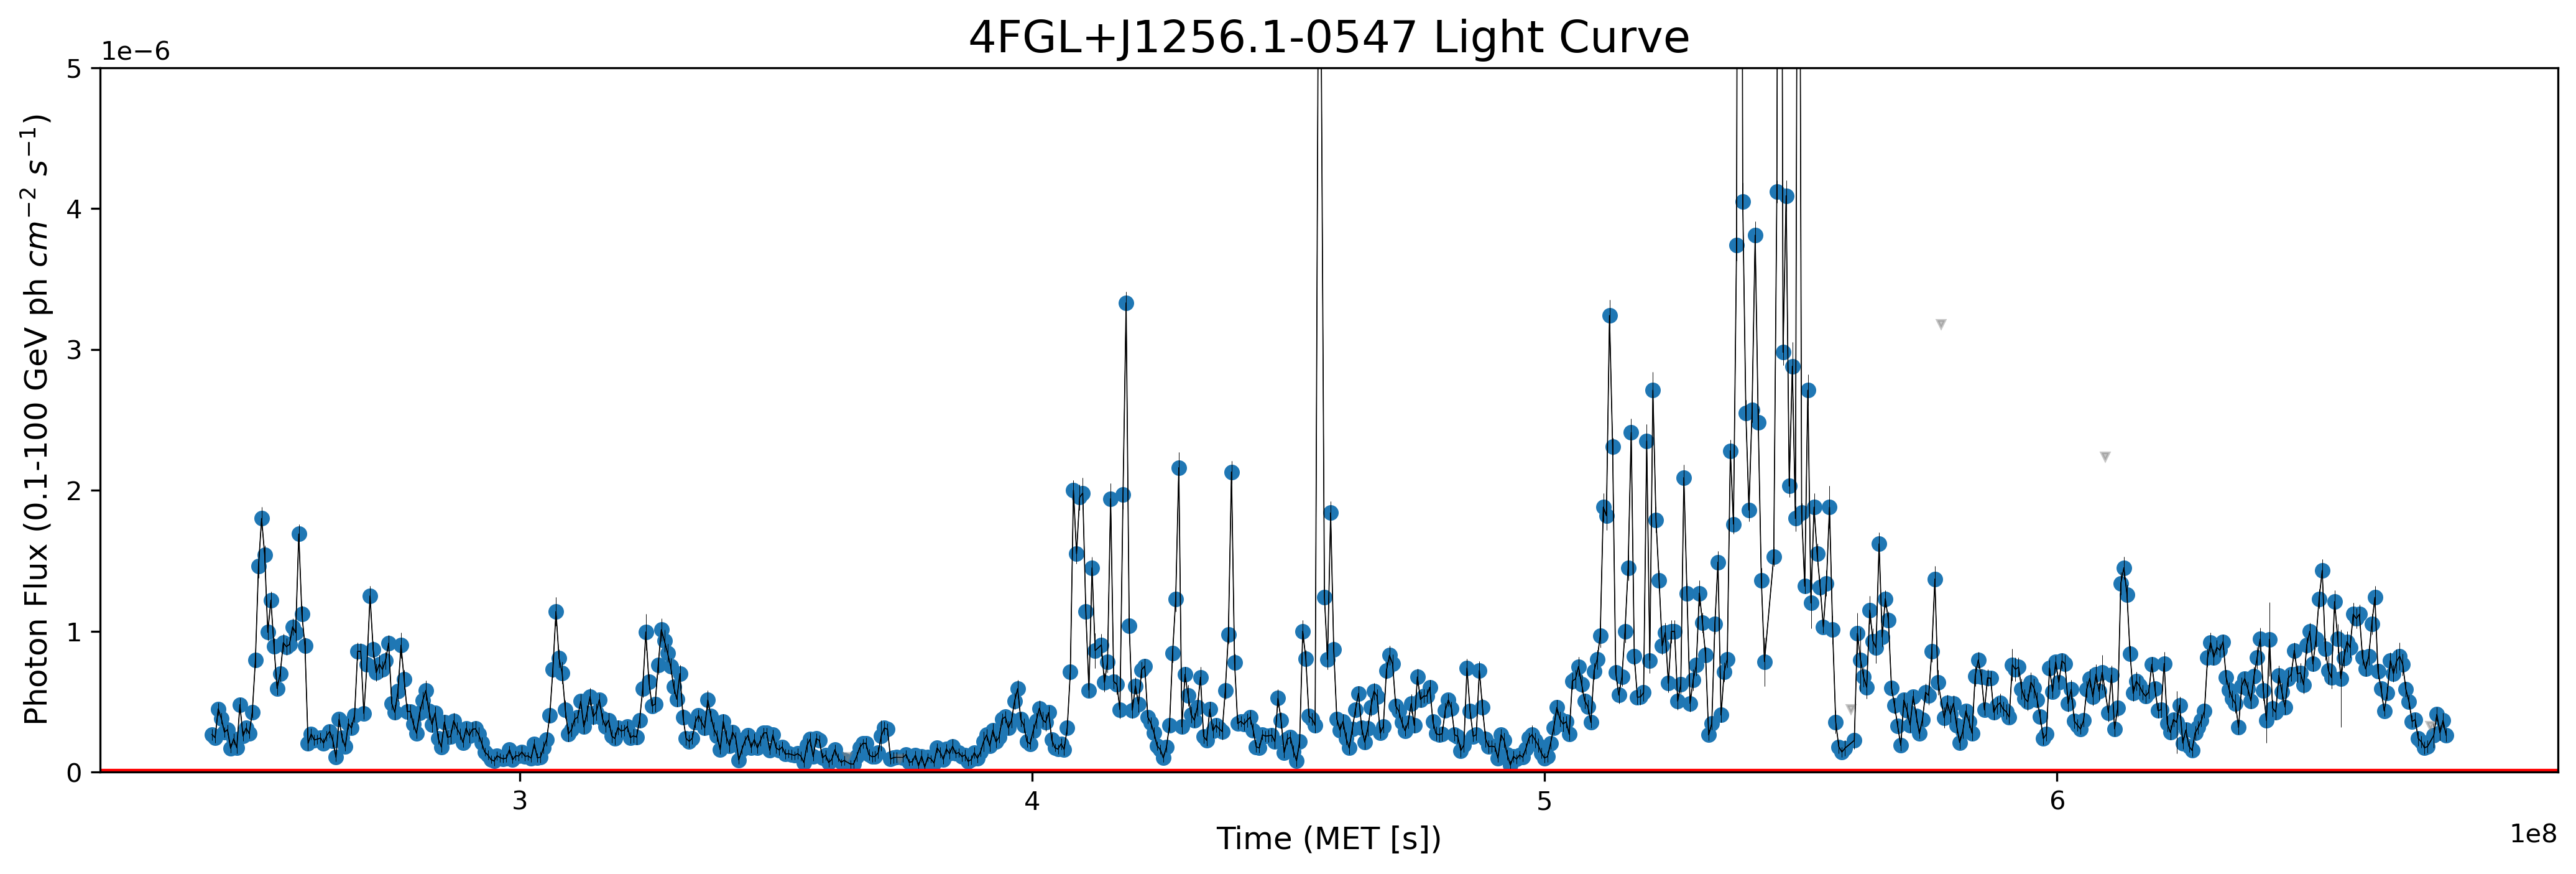

In [30]:
# Light Curve with the average flux

plt.figure(figsize=(17,5), dpi=300)

# flux
plt.plot(time4, flux4, '.', markersize=10)
plt.plot(time4, flux4, linewidth=0.4, color='black')

# upper_limits
plt.plot(time4_upper_lim, flux4_upper_lim, 'v', color='gray', markersize=3, alpha=0.45)

# error_bar
# plt.plot(time4_error, flux4_low_error, 'x', color='green', markersize=3, alpha=0.3)  # visualize the error
# plt.plot(time4_error, flux4_high_error, 'x', color='red', markersize=3, alpha=0.3)   # visualize the error
plt.errorbar(time4, flux4, yerr=flux4_high_error-flux4, linewidth=0.2, color='black', alpha=0.9)
plt.errorbar(time4, flux4, yerr=flux4-flux4_low_error, linewidth=0.2, color='black', alpha=0.9)

# integrated flux
plt.axhline(y=y4_true, color='r', linestyle='-')

dif = time4_upper_lim[6] - time4_upper_lim[0]

# plt.xlim(time4_upper_lim[0]-dif, time4_upper_lim[-1]+dif)
plt.ylim(0, 5e-6)
plt.title('4FGL+J1256.1-0547 Light Curve', fontsize='xx-large')
plt.xlabel('Time (MET [s])', fontsize=12)
plt.ylabel('Photon Flux (0.1-100 GeV ph $cm^{-2}$ $s^{-1}$)', fontsize=12)

### STEP 5

"Normalize" each lightcurve with respect to the average state we will be considering



In [31]:
# normalizing each lightcurve


